In [140]:
!wget -c http://download.tensorflow.org/example_images/flower_photos.tgz -O - | tar -xz
!tar -xzvf flower_photos.tgz

--2020-11-07 01:44:02--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.80, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘STDOUT’

-                   100%[===================>] 218.21M  90.2MB/s    in 2.4s    

2020-11-07 01:44:05 (90.2 MB/s) - written to stdout [228813984/228813984]

tar (child): flower_photos.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [142]:
import cupy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import os.path

np.random.seed(50)

CATEGORIES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

IMG_SIZE = 32

def get_data(DATADIR, raw_training_data, raw_testing_data):
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])

        count = 0

        for img in sorted(tqdm(os.listdir(path))):
            try:

                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                count+=1
                if count < num_files-99:
                    raw_training_data.append([new_array, class_num])
                else:
                    raw_testing_data.append([new_array, class_num])
            except Exception as e:
                pass

raw_training_data = []
raw_testing_data = []

DATADIR = "flower_photos"

get_data(DATADIR, raw_training_data, raw_testing_data)


print(len(raw_training_data), len(raw_testing_data))

100%|██████████| 799/799 [00:00<00:00, 1296421.24it/s]


3170 500


In [176]:
from skimage import color
from skimage import io
from sklearn.utils import shuffle
import keras
import matplotlib.pyplot as plt
%matplotlib inline

X_TRAIN = []
Y_TRAIN = []

X_TEST = []
Y_TEST = []

X_VAL = []
Y_VAL = []


for features,label in raw_training_data:
    X_TRAIN.append(features)
    Y_TRAIN.append(label)


for features,label in raw_testing_data:
    X_TEST.append(features)
    Y_TEST.append(label)

X_TRAIN = np.array(X_TRAIN).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X_TEST = np.array(X_TEST).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_TRAIN = np.array(Y_TRAIN)
X_TRAIN, Y_TRAIN = shuffle(X_TRAIN, Y_TRAIN)

X_TRAIN = X_TRAIN.astype(float) / 255.
X_TEST = X_TEST.astype(float) / 255.


X_TRAIN, X_VAL = X_TRAIN[:-500], X_TRAIN[-500:]
Y_TRAIN, Y_VAL = Y_TRAIN[:-500], Y_TRAIN[-500:]


X_TRAIN = X_TRAIN.reshape([X_TRAIN.shape[0], -1])
X_VAL = X_VAL.reshape([X_VAL.shape[0], -1])
X_TEST = X_TEST.reshape([X_TEST.shape[0], -1])

X_TRAIN -= np.mean(X_TRAIN, axis=0)
X_TEST -= np.mean(X_TEST, axis=0)

X_TRAIN /= np.std(X_TRAIN, axis=0)
X_TEST /= np.std(X_TEST, axis=0)




print (len(X_TRAIN), len(X_VAL))

2670 500


In [177]:
all_ws = []
class weights_layer():
    def __init__(self, fan_in, fan_out, lr=0.05, lamdaa = 0):
        self.lamdaa = lamdaa
        self.ws = []
        self.lr = lr
        self.ws = np.random.randn(fan_in, fan_out)/np.sqrt(fan_in)
        self.bs = np.zeros(fan_out)
        
    def forward(self,input):
        #all_ws.append(self.ws)
        return np.dot(input,self.ws) + self.bs
    
    def backward(self,input,grad_output):
        dout_din = np.dot(grad_output, self.ws.T)
        dout_dws = np.dot(input.T, grad_output)
        dout_dbs = grad_output.mean(axis=0)*input.shape[0]
        
        assert dout_dws.shape == self.ws.shape and dout_dbs.shape == self.bs.shape

        self.ws = self.ws - self.lr * dout_dws  #+ (self.lamdaa * np.sum(self.ws))/input.shape[0])  )
        self.bs = self.bs - self.lr * dout_dbs
        
        return dout_din

In [178]:
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, input):
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output*relu_grad

class tanh():
    def __init__(self):
        pass
    def forward(self, input):
        return np.tanh(input)

    def backward(self, input, grad_output):
      return grad_output*(1-np.tanh(input)**2)

class sigmoid():
    def __init__(self):
        pass
    def forward(self, input):
        return 1/(1+np.exp(-1* input))
    def backward(self, input, grad_output):
        return grad_output * (input*(1-input))


In [179]:

def NLL(expected_probabilities,actual_labels, m, lamdaa = 0):

    correct_prob = expected_probabilities[np.arange(len(expected_probabilities)),actual_labels]

    p = np.exp(correct_prob) / np.sum(np.exp(expected_probabilities),axis=-1)

    loss = -1 * np.log(p)
    
    s_reg = 0
    #for i in all_ws:
    #  s_reg += np.sum(np.square(i))
    
    return loss #+ (lamdaa * s_reg)/m

def back_NLL(expected_probabilities,actual_labels):

    hotmap = np.zeros_like(expected_probabilities)
    hotmap[np.arange(len(expected_probabilities)),actual_labels] = 1
    
    ratios = np.exp(expected_probabilities) / np.exp(expected_probabilities).sum(axis=-1,keepdims=True)
    
    return (- hotmap + ratios) / expected_probabilities.shape[0]


In [180]:
def run_batch(NN, X):
    all_layers_outputs = []
    received = X
    for layer in NN:
        all_layers_outputs.append(layer.forward(received))
        received = all_layers_outputs[-1]
    
    all_ws=[]
    assert len(all_layers_outputs) == len(NN)
    
    return all_layers_outputs

def predict(NN,X, Y):
    expected_probabilities = run_batch(NN,X)[-1]
    losses = NLL(expected_probabilities,Y, X.shape[0])
    return (expected_probabilities.argmax(axis=-1) , np.mean(losses))

def train(NN,X,acutal_labels):

    layers_outputs = run_batch(NN,X)
    layers_inputs = [X]+layers_outputs 
    expected_probs = layers_outputs[-1]
    loss = NLL(expected_probs,acutal_labels, X.shape[0])
    loss_grad = back_NLL(expected_probs,acutal_labels)

    for layer_index in range(len(NN))[::-1]:
        layer = NN[layer_index]
        
        loss_grad = layer.backward(layers_inputs[layer_index],loss_grad)
        
    return np.mean(loss)

In [181]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [182]:
max_count = 100
learning_rates = []
train_log = []
val_log = []
train_losses = []
val_losses = []
n_epochs = 10

for count in range(max_count):

  lr = 10**np.random.uniform(-1,-4) 
  
  NN = []
  NN.append(weights_layer(X_TRAIN.shape[1],200,lr))
  NN.append(ReLU())
  NN.append(weights_layer(200,200,lr))
  NN.append(ReLU())
  NN.append(weights_layer(200,5,lr))

  for epoch in range(n_epochs):

    train(NN,X_TRAIN,Y_TRAIN)

    train_predictions, train_loss = predict(NN,X_TRAIN, Y_TRAIN)

    val_predictions, val_loss = predict(NN,X_VAL, Y_VAL)

    train_log.append(np.mean(train_predictions==Y_TRAIN))

    val_log.append(np.mean(val_predictions==Y_VAL))

    train_losses.append(train_loss)

    val_losses.append(val_loss)

    learning_rates.append(lr)

    print("Trial %d epoch %d got t_acc = %f, v_acc = %f, t_loss = %f, and v_loss = %f at lr = %f" % (count, epoch, train_log[-1], train_losses[-1],val_losses[-1], val_log[-1], lr))

print()
print("Got highest train accuracy = %f at lr = %f" % (max(train_log), learning_rates[train_log.index(max(train_log))]))
print("Got highest val accuracy = %f at lr = %f" % (max(val_log), learning_rates[val_log.index(max(val_log))]))
print("Got lowest train loss = %f at lr = %f" % (min(train_losses), learning_rates[train_losses.index(min(train_losses))]))
print("Got lowest val loss = %f at lr = %f" % (min(val_losses), learning_rates[val_losses.index(min(val_losses))]))


Trial 0 epoch 0 got t_acc = 0.248315, v_acc = 1.661844, t_loss = 1.628924, and v_loss = 0.192000 at lr = 0.000926
Trial 0 epoch 1 got t_acc = 0.250562, v_acc = 1.659515, t_loss = 1.628108, and v_loss = 0.194000 at lr = 0.000926
Trial 0 epoch 2 got t_acc = 0.252434, v_acc = 1.657229, t_loss = 1.627304, and v_loss = 0.192000 at lr = 0.000926
Trial 0 epoch 3 got t_acc = 0.252809, v_acc = 1.654977, t_loss = 1.626514, and v_loss = 0.194000 at lr = 0.000926
Trial 0 epoch 4 got t_acc = 0.255805, v_acc = 1.652760, t_loss = 1.625734, and v_loss = 0.196000 at lr = 0.000926
Trial 0 epoch 5 got t_acc = 0.257303, v_acc = 1.650576, t_loss = 1.624967, and v_loss = 0.198000 at lr = 0.000926
Trial 0 epoch 6 got t_acc = 0.261049, v_acc = 1.648424, t_loss = 1.624211, and v_loss = 0.194000 at lr = 0.000926
Trial 0 epoch 7 got t_acc = 0.263296, v_acc = 1.646300, t_loss = 1.623467, and v_loss = 0.190000 at lr = 0.000926
Trial 0 epoch 8 got t_acc = 0.265169, v_acc = 1.644206, t_loss = 1.622735, and v_loss = 

100%|██████████| 1/1 [00:00<00:00, 165.01it/s]

Ran epoch 0 and got train accuracy = 0.262172 and val accuracy = 0.240000
Ran epoch 1 and got train accuracy = 0.314981 and val accuracy = 0.274000
Ran epoch 2 and got train accuracy = 0.350936 and val accuracy = 0.292000



100%|██████████| 1/1 [00:00<00:00, 268.30it/s]

Ran epoch 3 and got train accuracy = 0.378652 and val accuracy = 0.312000
Ran epoch 4 and got train accuracy = 0.395131 and val accuracy = 0.322000
Ran epoch 5 and got train accuracy = 0.413483 and val accuracy = 0.326000



100%|██████████| 1/1 [00:00<00:00, 170.00it/s]

Ran epoch 6 and got train accuracy = 0.432584 and val accuracy = 0.326000
Ran epoch 7 and got train accuracy = 0.438577 and val accuracy = 0.334000
Ran epoch 8 and got train accuracy = 0.452809 and val accuracy = 0.344000



100%|██████████| 1/1 [00:00<00:00, 212.51it/s]

Ran epoch 9 and got train accuracy = 0.469288 and val accuracy = 0.346000
Ran epoch 10 and got train accuracy = 0.477903 and val accuracy = 0.348000
Ran epoch 11 and got train accuracy = 0.483146 and val accuracy = 0.358000



100%|██████████| 1/1 [00:00<00:00, 198.19it/s]

Ran epoch 12 and got train accuracy = 0.488015 and val accuracy = 0.354000
Ran epoch 13 and got train accuracy = 0.496255 and val accuracy = 0.342000
Ran epoch 14 and got train accuracy = 0.503745 and val accuracy = 0.352000



100%|██████████| 1/1 [00:00<00:00, 191.90it/s]

Ran epoch 15 and got train accuracy = 0.513858 and val accuracy = 0.350000
Ran epoch 16 and got train accuracy = 0.518352 and val accuracy = 0.356000
Ran epoch 17 and got train accuracy = 0.526592 and val accuracy = 0.358000



100%|██████████| 1/1 [00:00<00:00, 219.05it/s]

Ran epoch 18 and got train accuracy = 0.531835 and val accuracy = 0.362000
Ran epoch 19 and got train accuracy = 0.537453 and val accuracy = 0.366000
Ran epoch 20 and got train accuracy = 0.541948 and val accuracy = 0.370000



100%|██████████| 1/1 [00:00<00:00, 241.54it/s]

Ran epoch 21 and got train accuracy = 0.545693 and val accuracy = 0.368000
Ran epoch 22 and got train accuracy = 0.552809 and val accuracy = 0.370000
Ran epoch 23 and got train accuracy = 0.556929 and val accuracy = 0.366000



100%|██████████| 1/1 [00:00<00:00, 204.68it/s]

Ran epoch 24 and got train accuracy = 0.563296 and val accuracy = 0.370000
Ran epoch 25 and got train accuracy = 0.565169 and val accuracy = 0.368000
Ran epoch 26 and got train accuracy = 0.571536 and val accuracy = 0.372000



100%|██████████| 1/1 [00:00<00:00, 165.68it/s]

Ran epoch 27 and got train accuracy = 0.574906 and val accuracy = 0.368000
Ran epoch 28 and got train accuracy = 0.580899 and val accuracy = 0.364000
Ran epoch 29 and got train accuracy = 0.585768 and val accuracy = 0.368000



100%|██████████| 1/1 [00:00<00:00, 153.11it/s]

Ran epoch 30 and got train accuracy = 0.589888 and val accuracy = 0.364000
Ran epoch 31 and got train accuracy = 0.595506 and val accuracy = 0.368000
Ran epoch 32 and got train accuracy = 0.599625 and val accuracy = 0.368000



100%|██████████| 1/1 [00:00<00:00, 158.14it/s]

Ran epoch 33 and got train accuracy = 0.605243 and val accuracy = 0.368000
Ran epoch 34 and got train accuracy = 0.609363 and val accuracy = 0.366000
Ran epoch 35 and got train accuracy = 0.610112 and val accuracy = 0.366000



100%|██████████| 1/1 [00:00<00:00, 174.04it/s]

Ran epoch 36 and got train accuracy = 0.619850 and val accuracy = 0.370000
Ran epoch 37 and got train accuracy = 0.620599 and val accuracy = 0.368000
Ran epoch 38 and got train accuracy = 0.624345 and val accuracy = 0.372000



100%|██████████| 1/1 [00:00<00:00, 256.11it/s]

Ran epoch 39 and got train accuracy = 0.624719 and val accuracy = 0.370000
Ran epoch 40 and got train accuracy = 0.628464 and val accuracy = 0.374000
Ran epoch 41 and got train accuracy = 0.632210 and val accuracy = 0.374000



100%|██████████| 1/1 [00:00<00:00, 272.73it/s]

Ran epoch 42 and got train accuracy = 0.637453 and val accuracy = 0.366000
Ran epoch 43 and got train accuracy = 0.640075 and val accuracy = 0.370000
Ran epoch 44 and got train accuracy = 0.643820 and val accuracy = 0.378000



100%|██████████| 1/1 [00:00<00:00, 216.82it/s]

Ran epoch 45 and got train accuracy = 0.649064 and val accuracy = 0.378000
Ran epoch 46 and got train accuracy = 0.655431 and val accuracy = 0.376000
Ran epoch 47 and got train accuracy = 0.658427 and val accuracy = 0.378000



100%|██████████| 1/1 [00:00<00:00, 233.69it/s]

Ran epoch 48 and got train accuracy = 0.664794 and val accuracy = 0.374000
Ran epoch 49 and got train accuracy = 0.666667 and val accuracy = 0.386000
Ran epoch 50 and got train accuracy = 0.670412 and val accuracy = 0.380000



100%|██████████| 1/1 [00:00<00:00, 213.55it/s]

Ran epoch 51 and got train accuracy = 0.678277 and val accuracy = 0.366000
Ran epoch 52 and got train accuracy = 0.680524 and val accuracy = 0.376000
Ran epoch 53 and got train accuracy = 0.685393 and val accuracy = 0.376000



100%|██████████| 1/1 [00:00<00:00, 199.52it/s]

Ran epoch 54 and got train accuracy = 0.690262 and val accuracy = 0.370000
Ran epoch 55 and got train accuracy = 0.692884 and val accuracy = 0.380000
Ran epoch 56 and got train accuracy = 0.695880 and val accuracy = 0.370000



100%|██████████| 1/1 [00:00<00:00, 198.42it/s]

Ran epoch 57 and got train accuracy = 0.699251 and val accuracy = 0.376000
Ran epoch 58 and got train accuracy = 0.703371 and val accuracy = 0.378000
Ran epoch 59 and got train accuracy = 0.705618 and val accuracy = 0.376000



100%|██████████| 1/1 [00:00<00:00, 242.45it/s]

Ran epoch 60 and got train accuracy = 0.708240 and val accuracy = 0.376000
Ran epoch 61 and got train accuracy = 0.710112 and val accuracy = 0.380000
Ran epoch 62 and got train accuracy = 0.717603 and val accuracy = 0.370000



100%|██████████| 1/1 [00:00<00:00, 107.97it/s]

Ran epoch 63 and got train accuracy = 0.718352 and val accuracy = 0.380000
Ran epoch 64 and got train accuracy = 0.723596 and val accuracy = 0.386000
Ran epoch 65 and got train accuracy = 0.727341 and val accuracy = 0.378000



100%|██████████| 1/1 [00:00<00:00, 344.53it/s]

Ran epoch 66 and got train accuracy = 0.730337 and val accuracy = 0.382000
Ran epoch 67 and got train accuracy = 0.731086 and val accuracy = 0.376000
Ran epoch 68 and got train accuracy = 0.735581 and val accuracy = 0.376000



100%|██████████| 1/1 [00:00<00:00, 185.46it/s]

Ran epoch 69 and got train accuracy = 0.737453 and val accuracy = 0.382000
Ran epoch 70 and got train accuracy = 0.740824 and val accuracy = 0.382000
Ran epoch 71 and got train accuracy = 0.743820 and val accuracy = 0.374000



100%|██████████| 1/1 [00:00<00:00, 196.67it/s]

Ran epoch 72 and got train accuracy = 0.747940 and val accuracy = 0.374000
Ran epoch 73 and got train accuracy = 0.749813 and val accuracy = 0.374000
Ran epoch 74 and got train accuracy = 0.755056 and val accuracy = 0.374000



100%|██████████| 1/1 [00:00<00:00, 166.50it/s]

Ran epoch 75 and got train accuracy = 0.756929 and val accuracy = 0.376000
Ran epoch 76 and got train accuracy = 0.762172 and val accuracy = 0.372000
Ran epoch 77 and got train accuracy = 0.761798 and val accuracy = 0.376000



100%|██████████| 1/1 [00:00<00:00, 151.04it/s]

Ran epoch 78 and got train accuracy = 0.766667 and val accuracy = 0.368000
Ran epoch 79 and got train accuracy = 0.768539 and val accuracy = 0.364000
Ran epoch 80 and got train accuracy = 0.769288 and val accuracy = 0.366000



100%|██████████| 1/1 [00:00<00:00, 203.93it/s]

Ran epoch 81 and got train accuracy = 0.773783 and val accuracy = 0.368000
Ran epoch 82 and got train accuracy = 0.771910 and val accuracy = 0.370000
Ran epoch 83 and got train accuracy = 0.778277 and val accuracy = 0.376000



100%|██████████| 1/1 [00:00<00:00, 146.52it/s]

Ran epoch 84 and got train accuracy = 0.777154 and val accuracy = 0.366000
Ran epoch 85 and got train accuracy = 0.783146 and val accuracy = 0.372000
Ran epoch 86 and got train accuracy = 0.781648 and val accuracy = 0.370000



100%|██████████| 1/1 [00:00<00:00, 208.21it/s]

Ran epoch 87 and got train accuracy = 0.790262 and val accuracy = 0.370000
Ran epoch 88 and got train accuracy = 0.786142 and val accuracy = 0.364000
Ran epoch 89 and got train accuracy = 0.794757 and val accuracy = 0.362000



100%|██████████| 1/1 [00:00<00:00, 196.32it/s]

Ran epoch 90 and got train accuracy = 0.791386 and val accuracy = 0.356000
Ran epoch 91 and got train accuracy = 0.799625 and val accuracy = 0.370000
Ran epoch 92 and got train accuracy = 0.799251 and val accuracy = 0.354000



100%|██████████| 1/1 [00:00<00:00, 191.15it/s]

Ran epoch 93 and got train accuracy = 0.803745 and val accuracy = 0.370000
Ran epoch 94 and got train accuracy = 0.801124 and val accuracy = 0.364000
Ran epoch 95 and got train accuracy = 0.808989 and val accuracy = 0.372000



100%|██████████| 1/1 [00:00<00:00, 151.39it/s]

Ran epoch 96 and got train accuracy = 0.805993 and val accuracy = 0.360000
Ran epoch 97 and got train accuracy = 0.815356 and val accuracy = 0.370000
Ran epoch 98 and got train accuracy = 0.809363 and val accuracy = 0.366000



100%|██████████| 1/1 [00:00<00:00, 151.05it/s]

Ran epoch 99 and got train accuracy = 0.816854 and val accuracy = 0.372000
Ran epoch 100 and got train accuracy = 0.810487 and val accuracy = 0.364000
Ran epoch 101 and got train accuracy = 0.822472 and val accuracy = 0.366000



100%|██████████| 1/1 [00:00<00:00, 138.50it/s]

Ran epoch 102 and got train accuracy = 0.813858 and val accuracy = 0.360000
Ran epoch 103 and got train accuracy = 0.821723 and val accuracy = 0.368000
Ran epoch 104 and got train accuracy = 0.816105 and val accuracy = 0.358000



100%|██████████| 1/1 [00:00<00:00, 178.00it/s]

Ran epoch 105 and got train accuracy = 0.826966 and val accuracy = 0.368000
Ran epoch 106 and got train accuracy = 0.820974 and val accuracy = 0.360000
Ran epoch 107 and got train accuracy = 0.825468 and val accuracy = 0.374000



100%|██████████| 1/1 [00:00<00:00, 186.44it/s]

Ran epoch 108 and got train accuracy = 0.818727 and val accuracy = 0.350000
Ran epoch 109 and got train accuracy = 0.828464 and val accuracy = 0.374000
Ran epoch 110 and got train accuracy = 0.819476 and val accuracy = 0.344000



100%|██████████| 1/1 [00:00<00:00, 189.12it/s]

Ran epoch 111 and got train accuracy = 0.834457 and val accuracy = 0.374000
Ran epoch 112 and got train accuracy = 0.822472 and val accuracy = 0.350000
Ran epoch 113 and got train accuracy = 0.832959 and val accuracy = 0.374000



100%|██████████| 1/1 [00:00<00:00, 206.59it/s]

Ran epoch 114 and got train accuracy = 0.818352 and val accuracy = 0.340000
Ran epoch 115 and got train accuracy = 0.832584 and val accuracy = 0.366000
Ran epoch 116 and got train accuracy = 0.822097 and val accuracy = 0.346000



100%|██████████| 1/1 [00:00<00:00, 334.50it/s]

Ran epoch 117 and got train accuracy = 0.835955 and val accuracy = 0.364000
Ran epoch 118 and got train accuracy = 0.825094 and val accuracy = 0.350000
Ran epoch 119 and got train accuracy = 0.840075 and val accuracy = 0.362000



100%|██████████| 1/1 [00:00<00:00, 210.48it/s]

Ran epoch 120 and got train accuracy = 0.829213 and val accuracy = 0.350000
Ran epoch 121 and got train accuracy = 0.847566 and val accuracy = 0.362000
Ran epoch 122 and got train accuracy = 0.840075 and val accuracy = 0.360000



100%|██████████| 1/1 [00:00<00:00, 195.71it/s]

Ran epoch 123 and got train accuracy = 0.851311 and val accuracy = 0.364000
Ran epoch 124 and got train accuracy = 0.843446 and val accuracy = 0.354000
Ran epoch 125 and got train accuracy = 0.854307 and val accuracy = 0.368000



100%|██████████| 1/1 [00:00<00:00, 169.52it/s]

Ran epoch 126 and got train accuracy = 0.845693 and val accuracy = 0.362000
Ran epoch 127 and got train accuracy = 0.853184 and val accuracy = 0.350000
Ran epoch 128 and got train accuracy = 0.850936 and val accuracy = 0.362000



100%|██████████| 1/1 [00:00<00:00, 204.88it/s]

Ran epoch 129 and got train accuracy = 0.856929 and val accuracy = 0.346000
Ran epoch 130 and got train accuracy = 0.853933 and val accuracy = 0.372000
Ran epoch 131 and got train accuracy = 0.865169 and val accuracy = 0.346000



100%|██████████| 1/1 [00:00<00:00, 142.52it/s]

Ran epoch 132 and got train accuracy = 0.858052 and val accuracy = 0.366000
Ran epoch 133 and got train accuracy = 0.866667 and val accuracy = 0.340000
Ran epoch 134 and got train accuracy = 0.857303 and val accuracy = 0.380000



100%|██████████| 1/1 [00:00<00:00, 231.23it/s]

Ran epoch 135 and got train accuracy = 0.863296 and val accuracy = 0.336000
Ran epoch 136 and got train accuracy = 0.857303 and val accuracy = 0.374000
Ran epoch 137 and got train accuracy = 0.864045 and val accuracy = 0.342000



100%|██████████| 1/1 [00:00<00:00, 264.11it/s]

Ran epoch 138 and got train accuracy = 0.861049 and val accuracy = 0.368000
Ran epoch 139 and got train accuracy = 0.870037 and val accuracy = 0.338000
Ran epoch 140 and got train accuracy = 0.872659 and val accuracy = 0.360000



100%|██████████| 1/1 [00:00<00:00, 177.81it/s]

Ran epoch 141 and got train accuracy = 0.875655 and val accuracy = 0.340000
Ran epoch 142 and got train accuracy = 0.873034 and val accuracy = 0.354000
Ran epoch 143 and got train accuracy = 0.876404 and val accuracy = 0.340000



100%|██████████| 1/1 [00:00<00:00, 189.02it/s]

Ran epoch 144 and got train accuracy = 0.873034 and val accuracy = 0.348000
Ran epoch 145 and got train accuracy = 0.881273 and val accuracy = 0.336000
Ran epoch 146 and got train accuracy = 0.881648 and val accuracy = 0.356000



100%|██████████| 1/1 [00:00<00:00, 246.30it/s]

Ran epoch 147 and got train accuracy = 0.893258 and val accuracy = 0.344000
Ran epoch 148 and got train accuracy = 0.887640 and val accuracy = 0.352000
Ran epoch 149 and got train accuracy = 0.895131 and val accuracy = 0.342000



100%|██████████| 1/1 [00:00<00:00, 271.99it/s]

Ran epoch 150 and got train accuracy = 0.883521 and val accuracy = 0.336000
Ran epoch 151 and got train accuracy = 0.894382 and val accuracy = 0.350000
Ran epoch 152 and got train accuracy = 0.876779 and val accuracy = 0.340000



100%|██████████| 1/1 [00:00<00:00, 201.53it/s]

Ran epoch 153 and got train accuracy = 0.892135 and val accuracy = 0.358000
Ran epoch 154 and got train accuracy = 0.876404 and val accuracy = 0.332000
Ran epoch 155 and got train accuracy = 0.884644 and val accuracy = 0.370000



100%|██████████| 1/1 [00:00<00:00, 241.72it/s]

Ran epoch 156 and got train accuracy = 0.873783 and val accuracy = 0.316000
Ran epoch 157 and got train accuracy = 0.878277 and val accuracy = 0.384000
Ran epoch 158 and got train accuracy = 0.861798 and val accuracy = 0.280000



100%|██████████| 1/1 [00:00<00:00, 188.59it/s]

Ran epoch 159 and got train accuracy = 0.864794 and val accuracy = 0.390000
Ran epoch 160 and got train accuracy = 0.852434 and val accuracy = 0.284000
Ran epoch 161 and got train accuracy = 0.872659 and val accuracy = 0.398000



100%|██████████| 1/1 [00:00<00:00, 184.50it/s]

Ran epoch 162 and got train accuracy = 0.871536 and val accuracy = 0.290000
Ran epoch 163 and got train accuracy = 0.891386 and val accuracy = 0.406000
Ran epoch 164 and got train accuracy = 0.894007 and val accuracy = 0.304000



100%|██████████| 1/1 [00:00<00:00, 159.85it/s]

Ran epoch 165 and got train accuracy = 0.906742 and val accuracy = 0.410000
Ran epoch 166 and got train accuracy = 0.900000 and val accuracy = 0.302000
Ran epoch 167 and got train accuracy = 0.913109 and val accuracy = 0.408000



100%|██████████| 1/1 [00:00<00:00, 215.48it/s]

Ran epoch 168 and got train accuracy = 0.910112 and val accuracy = 0.308000
Ran epoch 169 and got train accuracy = 0.918727 and val accuracy = 0.392000
Ran epoch 170 and got train accuracy = 0.913858 and val accuracy = 0.302000



100%|██████████| 1/1 [00:00<00:00, 190.26it/s]

Ran epoch 171 and got train accuracy = 0.920974 and val accuracy = 0.394000
Ran epoch 172 and got train accuracy = 0.918352 and val accuracy = 0.300000
Ran epoch 173 and got train accuracy = 0.924719 and val accuracy = 0.392000



100%|██████████| 1/1 [00:00<00:00, 166.76it/s]

Ran epoch 174 and got train accuracy = 0.924719 and val accuracy = 0.302000
Ran epoch 175 and got train accuracy = 0.924719 and val accuracy = 0.382000
Ran epoch 176 and got train accuracy = 0.922846 and val accuracy = 0.306000



100%|██████████| 1/1 [00:00<00:00, 191.22it/s]

Ran epoch 177 and got train accuracy = 0.922472 and val accuracy = 0.378000
Ran epoch 178 and got train accuracy = 0.916854 and val accuracy = 0.320000
Ran epoch 179 and got train accuracy = 0.904120 and val accuracy = 0.362000



100%|██████████| 1/1 [00:00<00:00, 332.01it/s]

Ran epoch 180 and got train accuracy = 0.898502 and val accuracy = 0.320000
Ran epoch 181 and got train accuracy = 0.867416 and val accuracy = 0.348000
Ran epoch 182 and got train accuracy = 0.874157 and val accuracy = 0.328000



100%|██████████| 1/1 [00:00<00:00, 165.19it/s]

Ran epoch 183 and got train accuracy = 0.852809 and val accuracy = 0.350000
Ran epoch 184 and got train accuracy = 0.881273 and val accuracy = 0.336000
Ran epoch 185 and got train accuracy = 0.884270 and val accuracy = 0.342000



100%|██████████| 1/1 [00:00<00:00, 186.33it/s]

Ran epoch 186 and got train accuracy = 0.902996 and val accuracy = 0.348000
Ran epoch 187 and got train accuracy = 0.905993 and val accuracy = 0.334000
Ran epoch 188 and got train accuracy = 0.919476 and val accuracy = 0.354000



100%|██████████| 1/1 [00:00<00:00, 209.23it/s]

Ran epoch 189 and got train accuracy = 0.925843 and val accuracy = 0.336000
Ran epoch 190 and got train accuracy = 0.937453 and val accuracy = 0.364000
Ran epoch 191 and got train accuracy = 0.934082 and val accuracy = 0.332000



100%|██████████| 1/1 [00:00<00:00, 180.49it/s]

Ran epoch 192 and got train accuracy = 0.938577 and val accuracy = 0.382000
Ran epoch 193 and got train accuracy = 0.932584 and val accuracy = 0.330000
Ran epoch 194 and got train accuracy = 0.934457 and val accuracy = 0.392000



100%|██████████| 1/1 [00:00<00:00, 224.28it/s]

Ran epoch 195 and got train accuracy = 0.922097 and val accuracy = 0.320000
Ran epoch 196 and got train accuracy = 0.925094 and val accuracy = 0.384000
Ran epoch 197 and got train accuracy = 0.913109 and val accuracy = 0.308000



100%|██████████| 1/1 [00:00<00:00, 260.76it/s]


Ran epoch 198 and got train accuracy = 0.916854 and val accuracy = 0.380000
Ran epoch 199 and got train accuracy = 0.904869 and val accuracy = 0.292000



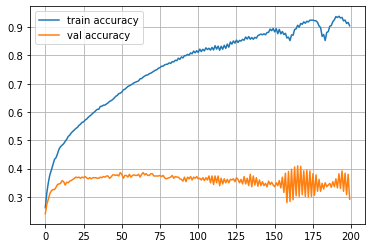

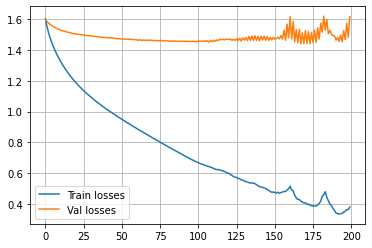


For Q4,
Best train accuracy: 0.9385767790262173
Best val accuracy: 0.41
Lowest Train Loss is 0.3353762067431931
Lowest Val Loss is 1.4397112111348938


In [186]:

lr=0.044230

train_log = []
val_log = []
losses = []
train_count = []
counter = 0
train_losses = []
val_losses = []

NN = []
NN.append(weights_layer(X_TRAIN.shape[1],200,lr))
NN.append(ReLU())
NN.append(weights_layer(200,200,lr))
NN.append(ReLU())
NN.append(weights_layer(200,5,lr))

n_epochs = 200

for epoch in range(n_epochs):

    for x_batch,y_batch in iterate_minibatches(X_TRAIN,Y_TRAIN,batchsize=2536,shuffle=True):
        train(NN,x_batch,y_batch)

    #train(NN,X_TRAIN,Y_TRAIN)

    train_predictions, train_loss = predict(NN,X_TRAIN, Y_TRAIN)

    val_predictions, val_loss = predict(NN,X_VAL, Y_VAL)

    train_log.append(np.mean(train_predictions==Y_TRAIN))

    val_log.append(np.mean(val_predictions==Y_VAL))

    train_losses.append(train_loss)

    val_losses.append(val_loss)

    print("Ran epoch %d and got train accuracy = %f and val accuracy = %f" % (epoch, train_log[-1], val_log[-1]))

print()
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(train_losses, label="Train losses") 

plt.plot(val_losses, label="Val losses") 

lowest_train_loss, lowest_val_loss = min(train_losses) , min(val_losses)

plt.grid()

plt.legend() 

lowest_x = val_losses.index(lowest_val_loss)

plt.show() 

print()
print("For Q4,")
print("Best train accuracy:",max(train_log))
print("Best val accuracy:",max(val_log))
print('Lowest Train Loss is ' + str(lowest_train_loss))
print('Lowest Val Loss is ' + str(lowest_val_loss))

For Q5,
For Category  daisy  , Got Accuracy 0.44
For Category  dandelion  , Got Accuracy 0.69
For Category  roses  , Got Accuracy 0.46
For Category  sunflowers  , Got Accuracy 0.65
For Category  tulips  , Got Accuracy 0.51


Text(0.5, 1.0, 'CCR')

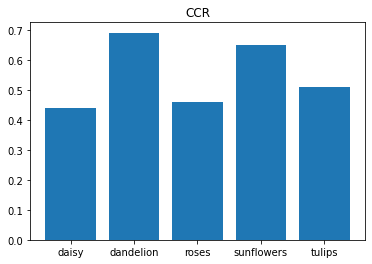

In [187]:
num_partition = 5
x_test_arrays = np.split(X_TEST, num_partition)
y_test_arrays = np.split(np.array(Y_TEST), num_partition)
n_images = len (x_test_arrays[0])

accuracies = []

print ('For Q5,')
for i in range(num_partition):
    class_predictions, class_loss = predict(NN,x_test_arrays[i], y_test_arrays[i])
    accuracy = np.mean(class_predictions==y_test_arrays[i])
    print('For Category ' , CATEGORIES[i],' , Got Accuracy' , accuracy)
    accuracies.append(accuracy)

y_pos = np.arange(len(CATEGORIES))

plt.bar(CATEGORIES, accuracies)
 
plt.xticks(CATEGORIES, CATEGORIES)
 
plt.title("CCR")



In [188]:
predicted_test, test_loss = predict(NN,X_TEST, Y_TEST)
accuracy = np.mean(predicted_test==np.array(Y_TEST))
    
print("ACCR = %f" % accuracy)

ACCR = 0.550000
